In [27]:
import cv2
from keras.models import load_model
import numpy as np
from collections import deque
import os

model = load_model('QuickDraw.h5')


def main():
    emojis = get_QD_emojis()
    cap = cv2.VideoCapture(0)
    Lower_green = np.array([110, 50, 50])
    Upper_green = np.array([130, 255, 255])
    pts = deque(maxlen=512)
    blackboard = np.zeros((480, 640, 3), dtype=np.uint8)
    digit = np.zeros((200, 200, 3), dtype=np.uint8)
    pred_class = 0

    while (cap.isOpened()):
        ret, img = cap.read()
        img = cv2.flip(img, 1)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.inRange(hsv, Lower_green, Upper_green)
        mask = cv2.erode(mask, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        # mask=cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)
        mask = cv2.dilate(mask, kernel, iterations=1)
        res = cv2.bitwise_and(img, img, mask=mask)
        cnts, heir = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        center = None

        if len(cnts) >= 1:
            cnt = max(cnts, key=cv2.contourArea)
            if cv2.contourArea(cnt) > 200:
                ((x, y), radius) = cv2.minEnclosingCircle(cnt)
                cv2.circle(img, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(img, center, 5, (0, 0, 255), -1)
                M = cv2.moments(cnt)
                center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
                pts.appendleft(center)
                for i in range(1, len(pts)):
                    if pts[i - 1] is None or pts[i] is None:
                        continue
                    cv2.line(blackboard, pts[i - 1], pts[i], (255, 255, 255), 7)
                    cv2.line(img, pts[i - 1], pts[i], (0, 0, 255), 2)
        elif len(cnts) == 0:
            if len(pts) != []:
                blackboard_gray = cv2.cvtColor(blackboard, cv2.COLOR_BGR2GRAY)
                blur1 = cv2.medianBlur(blackboard_gray, 15)
                blur1 = cv2.GaussianBlur(blur1, (5, 5), 0)
                thresh1 = cv2.threshold(blur1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                blackboard_cnts, i = cv2.findContours(thresh1.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                print ('black',blackboard_cnts)
                print('thresh',thresh1)
                if len(blackboard_cnts) >= 1:   
                    cnt = max(blackboard_cnts, key=cv2.contourArea)
                    print(cv2.contourArea(cnt))
                    if cv2.contourArea(cnt) > 2000:
                        x, y, w, h = cv2.boundingRect(cnt)
                        digit = blackboard_gray[y:y + h, x:x + w]
                        pred_probab, pred_class = keras_predict(model, digit)
                        print(pred_class, pred_probab)

            pts = deque(maxlen=512)
            blackboard = np.zeros((480, 640, 3), dtype=np.uint8)
            img = overlay(img, emojis[pred_class], 400, 250, 100, 100)
        cv2.imshow("Frame", img)
        k = cv2.waitKey(10)
        if k == 27:
            break


def keras_predict(model, image):
    processed = keras_process_image(image)
    print("processed: " + str(processed.shape))
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class


def keras_process_image(img):
    image_x = 28
    image_y = 28
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (-1, image_x, image_y, 1))
    return img


def get_QD_emojis():
    emojis_folder = 'qd_emo/'
    emojis = []
    for emoji in range(len(os.listdir(emojis_folder))):
        print(emoji)
        emojis.append(cv2.imread(emojis_folder + str(emoji) + '.png', -1))
    return emojis


def overlay(image, emoji, x, y, w, h):
    emoji = cv2.resize(emoji, (w, h))
    try:
        image[y:y + h, x:x + w] = blend_transparent(image[y:y + h, x:x + w], emoji)
    except:
        pass
    return image


def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:, :, :3]  # Grab the BRG planes
    overlay_mask = overlay_t_img[:, :, 3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))


keras_predict(model, np.zeros((50, 50, 1), dtype=np.uint8))
if __name__ == '__main__':
    main()

Using TensorFlow backend.


processed: (1, 28, 28, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0,

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [array([[[520, 121]],

       [[519, 122]],

       [[518, 122]],

       [[517, 123]],

       [[516, 123]],

       [[515, 124]],

       [[514, 125]],

       [[513, 126]],

       [[512, 127]],

       [[512, 128]],

       [[511, 129]],

       [[511, 130]],

       [[510, 131]],

       [[510, 132]],

       [[509, 133]],

       [[509, 134]],

       [[508, 135]],

       [[508, 136]],

       [[507, 137]],

       [[507, 138]],

       [[507, 139]],

       [[506, 140]],

       [[506, 141]],

       [[506, 142]],

       [[506, 143]],

       [[506, 144]],

       [[506, 145]],

       [[506, 146]],

       [[506, 147]],

       [[507, 148]],

       [[507, 149]],

       [[508, 150]],

       [[508, 151]],

       [[509, 152]],

       [[509, 153]],

       [[510, 154]],

       [[511, 155]],

       [[511, 156]],

       [[512, 157]],

       [[513, 158]],

       [[513, 159]],

       [[514, 160]],

       [[514, 161]],

       [[514, 162]],

       [[514, 163]],


('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [array([[[489, 216]],

       [[488, 217]],

       [[487, 217]],

       [[487, 218]],

       [[486, 219]],

       [[486, 220]],

       [[485, 221]],

       [[485, 222]],

       [[485, 223]],

       [[484, 224]],

       [[484, 225]],

       [[484, 226]],

       [[483, 227]],

       [[483, 228]],

       [[483, 229]],

       [[482, 230]],

       [[482, 231]],

       [[482, 232]],

       [[481, 233]],

       [[481, 234]],

       [[481, 235]],

       [[480, 236]],

       [[480, 237]],

       [[480, 238]],

       [[479, 239]],

       [[479, 240]],

       [[479, 241]],

       [[478, 242]],

       [[478, 243]],

       [[477, 244]],

       [[477, 245]],

       [[476, 246]],

       [[476, 247]],

       [[475, 248]],

       [[475, 249]],

       [[474, 250]],

       [[474, 251]],

       [[473, 252]],

       [[473, 253]],

       [[472, 254]],

       [[471, 255]],

       [[471, 256]],

       [[470, 257]],

       [[470, 258]],

       [[469, 259]],


('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0,

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
('black', [])
('thresh',

In [10]:

# load data


import numpy as np
import os
import pickle

files = os.listdir("/home/abhi/mainproject/quickdraw/data")
x = []
x_load = []
y = []
y_load = []


def load_data():
    count = 0
    for file in files:
        file = "/home/abhi/mainproject/quickdraw/data//" + file
        x = np.load(file)
        x = x.astype('float32') / 255.
        x = x[0:10000, :]
        x_load.append(x)
        y = [count for _ in range(10000)]
        count += 1
        y = np.array(y).astype('float32')
        y = y.reshape(y.shape[0], 1)
        y_load.append(y)

    return x_load, y_load


features, labels = load_data()
# print ("features",features)
# print ("label",labels)
features = np.array(features).astype('float32')

labels = np.array(labels).astype('float32')
# print ("feature",features)
# print ("features1",features[0])
# print("labels1",labels[0])
features=features.reshape(features.shape[0]*features.shape[1],features.shape[2])
labels=labels.reshape(labels.shape[0]*labels.shape[1],labels.shape[2])
# print ("features",features[0])
print("labels",labels[1])
# from keras.utils import np_utils
# labels = np_utils.to_categorical(labels)
# print("labels",labels)
with open("features", "wb") as f:
    pickle.dump(features, f, protocol=2)
with open("labels", "wb") as f:
    pickle.dump(labels, f, protocol=2)


('labels', array([0.], dtype=float32))


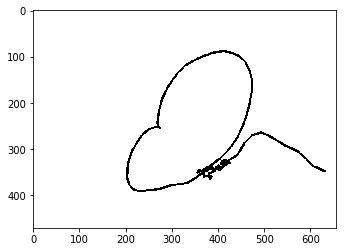

In [2]:
# drawing  using pen


import numpy as np
import cv2
from collections import deque
from matplotlib import pyplot as plt

# Define the upper and lower boundaries for a color to be considered "Blue"
blueLower = np.array([100, 60, 60])
blueUpper = np.array([140, 255, 255])

# Define a 5x5 kernel for erosion and dilation
kernel = np.ones((5, 5), np.uint8)

# Setup deques to store separate colors in separate arrays
points = deque(maxlen=512)

# Setup the Paint interface
paintWindow = np.zeros((471,656,3)) + 255 #paint window
cv2.namedWindow('Paint', cv2.WINDOW_AUTOSIZE)

# Load the video
camera = cv2.VideoCapture(0)

# Keep looping
while True:
    # Grab the current paintWindow
    key = cv2.waitKey(1)
    (grabbed, frame) = camera.read()
    frame = cv2.flip(frame, 1)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Check to see if we have reached the end of the video
    if not grabbed:
        break

    # Determine which pixels fall within the blue boundaries and then blur the binary image
    blueMask = cv2.inRange(hsv, blueLower, blueUpper)
    blueMask = cv2.erode(blueMask, kernel, iterations=2)
    blueMask = cv2.morphologyEx(blueMask, cv2.MORPH_OPEN, kernel)
    blueMask = cv2.dilate(blueMask, kernel, iterations=1)

    # Find contours in the image
    cnts, x  = cv2.findContours(blueMask.copy(), cv2.RETR_EXTERNAL,
    	cv2.CHAIN_APPROX_SIMPLE)
    center = None

    # Check to see if any contours were found
    if len(cnts) > 0:
    	# Sort the contours and find the largest one -- we
    	# will assume this contour correspondes to the area of the bottle cap
        cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        # Get the radius of the enclosing circle around the found contour
        ((x, y), radius) = cv2.minEnclosingCircle(cnt)
        # Draw the circle around the contour
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
        # Get the moments to calculate the center of the contour (in this case Circle)
        M = cv2.moments(cnt)
        
        #finding the center of the circle
        center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
    points.appendleft(center)
    # Append the next deque when no contours are detected (i.e., bottle cap reversed,blue not detected
    for i in range(1,len(points)):
        if points[i-1] is None or points[i] is None:
            continue
        cv2.line(frame, points[i - 1], points[i], (255, 0, 0), 2)
        cv2.line(paintWindow, points[i - 1], points[i], (0, 0, 0), 3)
                

    # Show the frame and the paintWindow image
    cv2.imshow("Tracking_frame", frame)
    cv2.imshow("PaintWindow", paintWindow)
    
    if key & 0xFF == ord('r'):
        points = deque(maxlen=512)
        paintWindow[:,:,:] = 255
    if key & 0xFF == ord('c'):
            plt.imshow(paintWindow)
            plt.show()
	# If the 'q' key is pressed, stop the loop
    if key == 27:
        break

# Cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()


In [3]:
import numpy as np
import os 
files = "/home/abhi/mainproject/quickdraw/data/full_numpy_bitmap_moon.npy"
x = np.load(files)
print (x[1])
x = x[0:10000, :] 
print ("hello",len(x))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  36  54  68  68  56   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   5  81 176 236 255 255 255 255
 255 205  78   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  45 211 255 221 147  92  68  56  51  90 213 255 205  78   1   0   0
   0   0   0   0   0   0   0   0   0   0  99 247 226  75   1   0   0   0
   0   0   0   2  87 213 255 205  78   0   0   0   0   0   0   0   0   0
   0 121 254 177  17   0   0   0   0   0   0   0   0   0   0   2  87 213
 255 175  18   0   0   0   0   0   0   0 138 255 155   3   0   0   0   0
   0   0   0   0   0   0   0   0   0   2 105 246 202   3   0   0   0   0
   0  84 255 141   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  77 255 114   0   0   0   0  23 235 194   2   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [17]:
import cv2
from keras.models import load_model
import numpy as np
from collections import deque
import os

model = load_model('QuickDraw.h5')


def main():
    emojis = get_QD_emojis()
    cap = cv2.VideoCapture(0)
    Lower_green = np.array([100, 60, 60])
    Upper_green = np.array([140, 255, 255])
    pts = deque(maxlen=512)
    blackboard = np.zeros((480, 640, 3), dtype=np.uint8)
    digit = np.zeros((200, 200, 3), dtype=np.uint8)
    pred_class = 0

    while (cap.isOpened()):
        ret, img = cap.read()
        img = cv2.flip(img, 1)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.inRange(hsv, Lower_green, Upper_green)
        mask = cv2.erode(mask, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        # mask=cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)
        mask = cv2.dilate(mask, kernel, iterations=1)
        res = cv2.bitwise_and(img, img, mask=mask)
        cnts, heir = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        center = None

        if len(cnts) >= 1:
            cnt = max(cnts, key=cv2.contourArea)
            if cv2.contourArea(cnt) > 200:
                ((x, y), radius) = cv2.minEnclosingCircle(cnt)
                cv2.circle(img, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(img, center, 5, (0, 0, 255), -1)
                M = cv2.moments(cnt)
                center = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
                pts.appendleft(center)
                for i in range(1, len(pts)):
                    if pts[i - 1] is None or pts[i] is None:
                        continue
                    cv2.line(blackboard, pts[i - 1], pts[i], (255, 255, 255), 7)
                    cv2.line(img, pts[i - 1], pts[i], (0, 0, 255), 2)
        elif len(cnts) == 0:
            if len(pts) != []:
                blackboard_gray = cv2.cvtColor(blackboard, cv2.COLOR_BGR2GRAY)
                blur1 = cv2.medianBlur(blackboard_gray, 15)
                blur1 = cv2.GaussianBlur(blur1, (5, 5), 0)
                thresh1 = cv2.threshold(blur1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                blackboard_cnts, i = cv2.findContours(thresh1.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#                 print ('black',blackboard_cnts)
#                 print('thresh',thresh1)
                if len(blackboard_cnts) >= 1:   
                    cnt = max(blackboard_cnts, key=cv2.contourArea)
                    print(cv2.contourArea(cnt))
                    if cv2.contourArea(cnt) > 2000:
                        x, y, w, h = cv2.boundingRect(cnt)
                        digit = blackboard_gray[y:y + h, x:x + w]
                        pred_probab, pred_class = keras_predict(model, digit)
                        print("predications")
                        print("class",pred_class,"prob", pred_probab)

            pts = deque(maxlen=512)
            blackboard = np.zeros((480, 640, 3), dtype=np.uint8)
            img = overlay(img, emojis[pred_class], 400, 250, 100, 100)
        cv2.imshow("Frame", img)
        k = cv2.waitKey(10)
        if k == 27:
            break


def keras_predict(model, image):
    processed = keras_process_image(image)
    print("processed: " + str(processed.shape))
    pred_probab = model.predict(processed)[0]
    pred_class = list(pred_probab).index(max(pred_probab))
    return max(pred_probab), pred_class


def keras_process_image(img):
    image_x = 28
    image_y = 28
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (-1, image_x, image_y, 1))
    return img


def get_QD_emojis():
    emojis_folder = 'qd_emo/'
    emojis = []
    for emoji in range(len(os.listdir(emojis_folder))):
        print("emoji",emoji)
        emojis.append(cv2.imread(emojis_folder + str(emoji) + '.png', -1))
    return emojis


def overlay(image, emoji, x, y, w, h):
    emoji = cv2.resize(emoji, (w, h))
    try:
        image[y:y + h, x:x + w] = blend_transparent(image[y:y + h, x:x + w], emoji)
    except:
        pass
    return image


def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:, :, :3]  # Grab the BRG planes
    overlay_mask = overlay_t_img[:, :, 3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))


keras_predict(model, np.zeros((50, 50, 1), dtype=np.uint8))
if __name__ == '__main__':
    main()

processed: (1, 28, 28, 1)
('emoji', 0)
('emoji', 1)
('emoji', 2)
('emoji', 3)
('emoji', 4)
('emoji', 5)
('emoji', 6)
('emoji', 7)
('emoji', 8)
('emoji', 9)
('emoji', 10)
('emoji', 11)
('emoji', 12)
('emoji', 13)
('emoji', 14)
('emoji', 15)
2789.5
processed: (1, 28, 28, 1)
predications
('class', 0, 'prob', 1.0)
40532.0
processed: (1, 28, 28, 1)
predications
('class', 1, 'prob', 1.0)
1125.5
8110.0
processed: (1, 28, 28, 1)
predications
('class', 0, 'prob', 1.0)
180.0


In [12]:
x=[1,2,3,4,5,6]
x = [0:2, :] 


SyntaxError: invalid syntax (<ipython-input-12-9c74389303b1>, line 2)

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.layers import Dense,Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.utils import np_utils, print_summary
import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import pickle
from keras.callbacks import TensorBoard

def keras_model(image_x, image_y):
    num_of_classes = 2
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(image_x,image_y,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(num_of_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    filepath = "QuickDraw.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    return model, callbacks_list


def loadFromPickle():
    with open("features", "rb") as f:
        features = np.array(pickle.load(f))
    with open("labels", "rb") as f:
        labels = np.array(pickle.load(f))

    return features, labels


def augmentData(features, labels):
    features = np.append(features, features[:, :, ::-1], axis=0)
    labels = np.append(labels, -labels, axis=0)
    return features, labels


def prepress_labels(labels):
    labels = np_utils.to_categorical(labels)
    return labels


def main():
    features, labels = loadFromPickle()
    # features, labels = augmentData(features, labels)
    features, labels = shuffle(features, labels)
    labels=prepress_labels(labels)
#     print("labels",labels[1])
    train_x, test_x, train_y, test_y = train_test_split(features, labels, random_state=0,
                                                        test_size=0.1)
    train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
    test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
    model, callbacks_list = keras_model(28,28)
    print_summary(model)
    model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=3, batch_size=64,
              callbacks=[TensorBoard(log_dir="QuickDraw")])
    model.save('QuickDraw.h5')


main()


('labels', array([0., 1.], dtype=float32))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (Non

KeyboardInterrupt: 